<a href="https://colab.research.google.com/github/samer-glitch/samerelhajjhassan/blob/main/Part1%20Simplified%20to%20LightGBM%20AND%20Part2%20Optimization%20AND%20part3%20GUI%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import files
uploaded = files.upload()

Saving updated_transactions_with_number_of_tries_within1minute_sameAmountCountry.csv to updated_transactions_with_number_of_tries_within1minute_sameAmountCountry (1).csv


In [15]:
from google.colab import files
uploaded = files.upload()

Saving updated_transactions_with_number_of_tries_within1minute(Noseconds).csv to updated_transactions_with_number_of_tries_within1minute(Noseconds).csv


In [16]:
from google.colab import files
uploaded = files.upload()

In [11]:
from google.colab import files
uploaded = files.upload()

Saving updated_transactions_with_number_of_tries(within and without)1min.csv to updated_transactions_with_number_of_tries(within and without)1min.csv


In [7]:
from google.colab import files
uploaded = files.upload()

Saving PSP_Jan_Feb_2019modfied1_with_tries.csv to PSP_Jan_Feb_2019modfied1_with_tries.csv


Dataset loaded. Time elapsed: 0.12 seconds
Preprocessing completed. Time elapsed: 0.24 seconds
Class imbalance handled. Time elapsed: 5.45 seconds

Model: LightGBM
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 40340, number of negative: 40182
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4592
[LightGBM] [Info] Number of data points in the train set: 80522, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500981 -> initscore=0.003924
[LightGBM] 

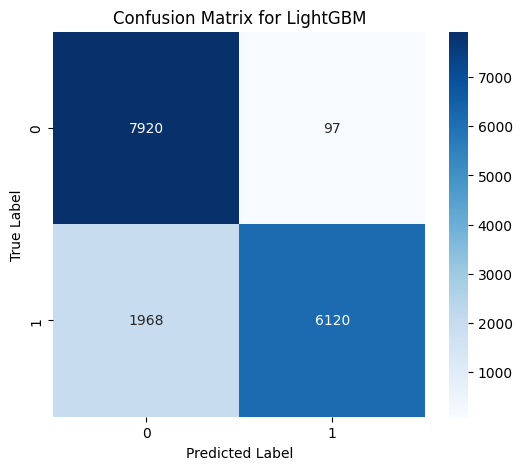

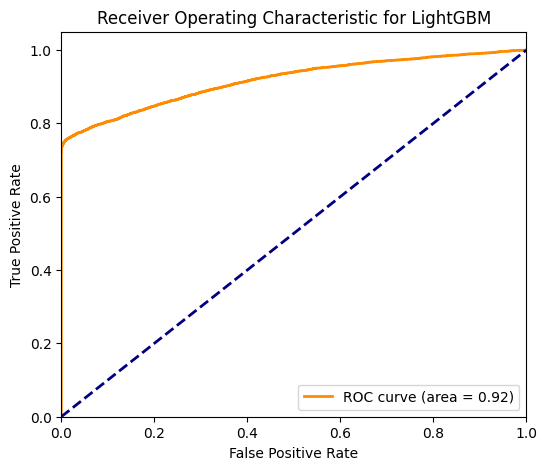

Accuracy Score: 0.8717789506364483
ROC AUC Score:(on test data) 0.917172484731074
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.99      0.88      8017
           1       0.98      0.76      0.86      8088

    accuracy                           0.87     16105
   macro avg       0.89      0.87      0.87     16105
weighted avg       0.89      0.87      0.87     16105

Model LightGBM evaluated. Time elapsed: 200.07 seconds


In [13]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
from lightgbm import LGBMClassifier
from imblearn.over_sampling import ADASYN
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Start timer
start_time = time.time()

# Load the dataset
transactions = pd.read_csv('PSP_Jan_Feb_2019modfied1_with_tries.csv')
print(f"Dataset loaded. Time elapsed: {time.time() - start_time:.2f} seconds")

# Preprocessing
X = transactions.drop(['success', 'tmsp'], axis=1)
y = transactions['success']
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(exclude=['object', 'category']).columns

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(), categorical_features)
])

X_processed = preprocessor.fit_transform(X)
print(f"Preprocessing completed. Time elapsed: {time.time() - start_time:.2f} seconds")

# Handling class imbalance with ADASYN
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_processed, y)
print(f"Class imbalance handled. Time elapsed: {time.time() - start_time:.2f} seconds")

# Define StratifiedKFold for cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grid for LightGBM
lgbm_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Define LightGBM model
model = ('LightGBM', LGBMClassifier(random_state=42), lgbm_param_grid)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_test, y_pred_proba, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {model_name}')
    plt.legend(loc='lower right')
    plt.show()

# Train and evaluate LightGBM model
model_name, model, param_grid = model
print("\033[1m" + f"\nModel: {model_name}" + "\033[0m")

grid_search = GridSearchCV(model, param_grid, cv=stratified_kfold, scoring='roc_auc', verbose=2, n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)
best_model = grid_search.best_estimator_

cv_results = cross_val_score(best_model, X_resampled, y_resampled, cv=stratified_kfold, scoring='roc_auc')

print("Best Hyperparameters:", grid_search.best_params_)
print("Best ROC AUC Score (on validation set):", grid_search.best_score_)
print("Cross-Validation ROC AUC Scores:", cv_results)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, model_name)

plot_roc_curve(y_test, y_pred_proba, model_name)

print("\033[1m" + "Accuracy Score:" + "\033[0m", accuracy_score(y_test, y_pred))
print("\033[1m" + "ROC AUC Score:(on test data)" + "\033[0m", roc_auc_score(y_test, y_pred_proba))
print("\033[1m" + "Classification Report:\n" + "\033[0m", classification_report(y_test, y_pred))
print(f"Model {model_name} evaluated. Time elapsed: {time.time() - start_time:.2f} seconds")

In [39]:
import pandas as pd
import random
from datetime import datetime
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from lightgbm import LGBMClassifier
from prettytable import PrettyTable

# Load your data
transactions = pd.read_csv('PSP_Jan_Feb_2019modfied1_with_tries.csv')  # Replace with your actual file path
psp_fees_df = pd.read_csv('psp_fees.csv')
print("PSP Fees:", psp_fees_df)

# Define your preprocessor (ColumnTransformer)
numerical_features = ['amount', 'second', 'minute', 'hour', 'day', 'weekday', 'number_of_tries']
categorical_features = ['country', 'PSP', 'card']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Fit the preprocessor with your data
X = transactions.drop(['success', 'tmsp'], axis=1)  # Assuming 'success' and 'tmsp' are not features
y = transactions['success']  # Target variable
preprocessor.fit(X)

# Load and prepare your LightGBM model
# Replace the following line with your actual trained model loading
best_lgbm_model = LGBMClassifier()  # Replace with your actual trained model
best_lgbm_model.fit(preprocessor.transform(X), y)

def assign_weights(transaction):
    # Modify time weight based on specified conditions
    time_weight = 1.0
    if 12 <= transaction['hour'] <= 19 and transaction['number_of_tries'] == 1:
        time_weight = random.uniform(1.1, 1.3)

    # Modify weekend weight based on specified conditions
    weekend_weight = random.uniform(0.8, 1.2)
    if transaction['weekday'] in [4, 5] and transaction['hour'] >= 12 and transaction['number_of_tries'] == 1:
        weekend_weight = random.uniform(1.1, 1.3)

    weights = {
        'time_weight': time_weight,
        'country_weight': {'Germany': 0.8, 'Switzerland': 1.0, 'Austria': 1.15}.get(transaction['country'], 1.0),
        'card_weight': {'Diners': 0.9, 'Visa': 1.0, 'Master': 1.0}.get(transaction['card'], 1.0),
        'psp_weight': 1.0,
        'amount_weight': 0.5 if transaction['amount'] < 100 else 1.2 if transaction['amount'] > 500 else 1.0,
        'tries_weight': 0.9 if transaction['number_of_tries'] == 1 else 0,
        'weekend_weight': weekend_weight
    }
    return weights

def calculate_expected_cost(transaction, probability, psp_name, psp_fees_df):
    # Change threshold for 'Goldcard' assignment
    high_amount_threshold = 500
    if transaction['amount'] > high_amount_threshold:
        psp_name = 'Goldcard'

    fees = psp_fees_df[psp_fees_df['PSP'] == psp_name]
    success_fee = fees['PSP_Fee_Successful'].values[0]
    failure_fee = fees['PSP_Fee_Failed'].values[0]

    weights = assign_weights(transaction)
    secure_cost_factor = 1.1 if transaction['3D_secured'] == 1 else 0.9

    expected_cost = ((probability * success_fee * weights['psp_weight'] * weights['time_weight'] *
                      weights['amount_weight'] * weights['tries_weight'] * weights['weekend_weight']) +
                     ((1 - probability) * failure_fee * weights['country_weight'] * weights['card_weight'])) * secure_cost_factor
    return expected_cost

def generate_random_date():
    year = random.randint(2024, 2025)
    month = random.randint(1, 12)
    day = random.randint(1, 28)
    hour = random.randint(0, 23)
    minute = random.randint(0, 59)
    second = random.randint(0, 59)
    return datetime(year, month, day, hour, minute, second)  # Return datetime object

def generate_weighted_number_of_tries():
    numbers = list(range(1, 10))  # Numbers from 1 to 9
    weights = [10, 9, 8, 7, 6, 5, 4, 1, 1]  # Higher weights for 1, 2, and 3
    return random.choices(numbers, weights)[0]

def generate_new_transaction():
    transaction = {
        'tmsp': generate_random_date(),
        'Unnamed: 0': random.randint(0, 1000),
        'country': random.choice(['Germany', 'Switzerland', 'Austria']),
        'amount': random.randint(5, 10000),
        'PSP': random.choice(['Moneycard', 'Goldcard', 'UK_Card', 'Simplecard']),
        '3D_secured': random.randint(0, 1),
        'card': random.choice(['Visa', 'Master', 'Diners']),
        'second': random.randint(0, 59),
        'minute': random.randint(0, 59),
        'hour': random.randint(0, 23),
        'day': random.randint(1, 28),
        'weekday': random.randint(0, 6),
        'number_of_tries': generate_weighted_number_of_tries()  # Use the helper function
    }
    return transaction


def find_best_psp(transaction, psp_fees_df, preprocessor, model):
    min_cost = float('inf')
    best_psp = None
    debug_info = {}

    processed_transaction = pd.DataFrame([transaction])
    processed_transaction = preprocessor.transform(processed_transaction)

    current_probability = model.predict_proba(processed_transaction)[:, 1][0]

    for psp in psp_fees_df['PSP']:
        transaction['PSP'] = psp
        cost = calculate_expected_cost(transaction, current_probability, psp, psp_fees_df)
        debug_info[psp] = {'Probability': current_probability, 'Cost': cost}
        if cost < min_cost:
            min_cost = cost
            best_psp = psp

    print("Debug Info:", debug_info)
    return best_psp, min_cost

num_transactions = 15
new_transactions = [generate_new_transaction() for _ in range(num_transactions)]

for transaction in new_transactions:
    best_psp, expected_cost = find_best_psp(transaction, psp_fees_df, preprocessor, best_lgbm_model)
    transaction['PSP'] = best_psp

    formatted_data = []
    formatted_data.append(f"Date & Time: {transaction['tmsp'].strftime('%Y-%m-%d %H:%M:%S')}")
    formatted_data.append(f"Country: {transaction['country']}")
    formatted_data.append(f"Amount: {transaction['amount']}")
    formatted_data.append(f"3D Secured: {'Yes' if transaction['3D_secured'] == 1 else 'No'}")
    formatted_data.append(f"Card Type: {transaction['card']}")
    formatted_data.append(f"Number of Tries: {transaction['number_of_tries']}")
    formatted_transaction_data = '\n'.join(formatted_data)

    table = PrettyTable()
    table.field_names = ["Transaction Details", "Recommended PSP"]
    table.align = "l"
    table.add_row([formatted_transaction_data, f"PSP: {best_psp}\nExpected Cost: {expected_cost:.2f}"])
    print(table)
    print("\n")

PSP Fees:           PSP  PSP_Fee_Successful  PSP_Fee_Failed
0   Moneycard                   5             2.0
1    Goldcard                  10             5.0
2     UK_Card                   3             1.0
3  Simplecard                   2             0.5
[LightGBM] [Info] Number of positive: 10228, number of negative: 40182
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 472
[LightGBM] [Info] Number of data points in the train set: 50410, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.202896 -> initscore=-1.368290
[LightGBM] [Info] Start training from score -1.368290
Debug Info: {'Moneycard': {'Probability': 0.16460583042389884, 'Cost': 4.323164827556323}, 'Goldcard': {'Probability': 0.16460583042389884, 'Cost': 4.323164827556323}, 'UK_Card': {'Pr

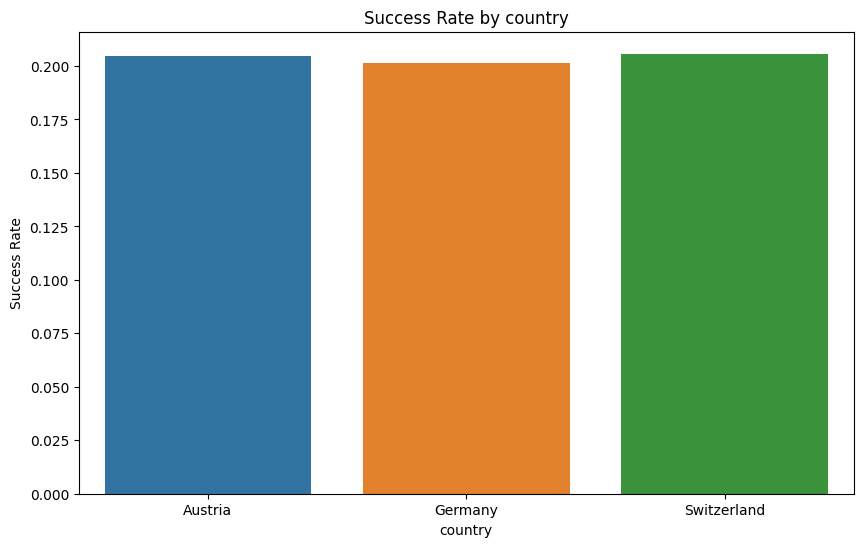

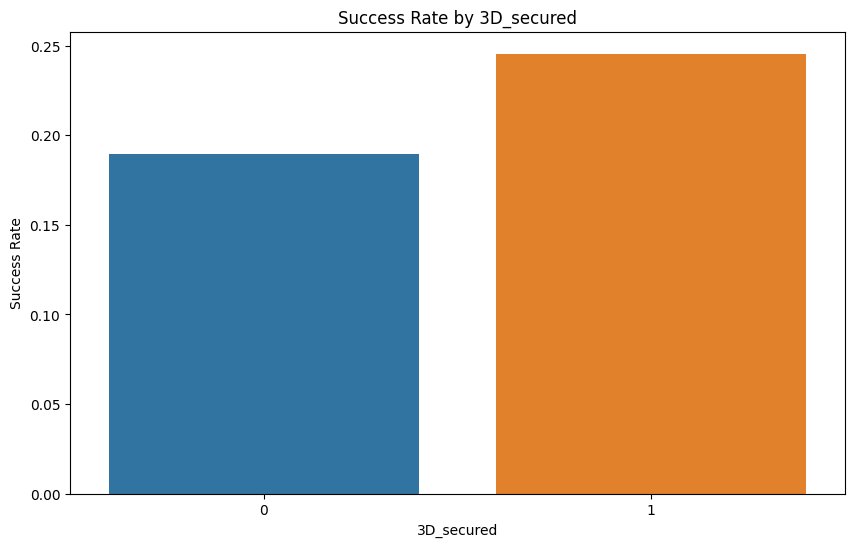

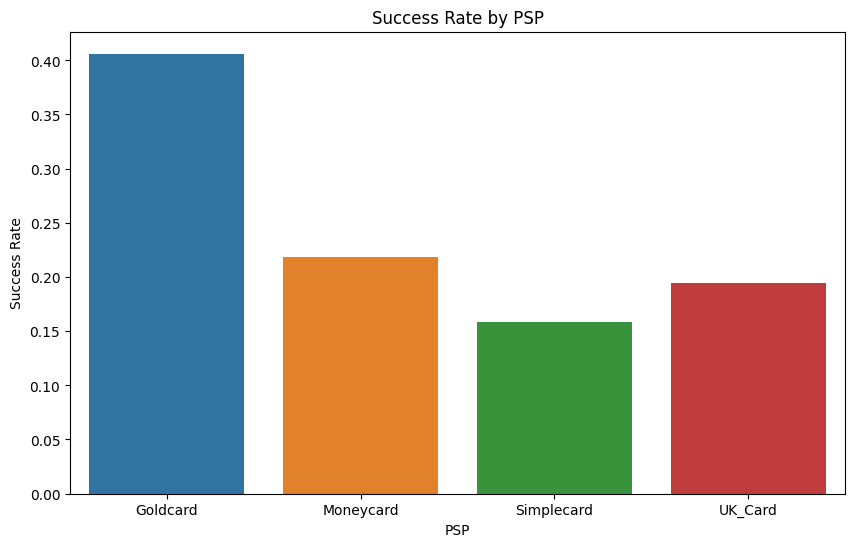

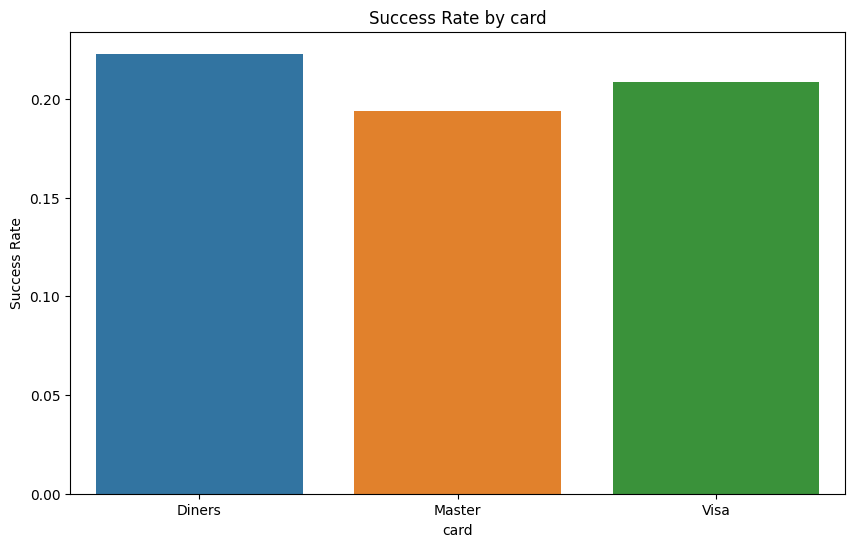

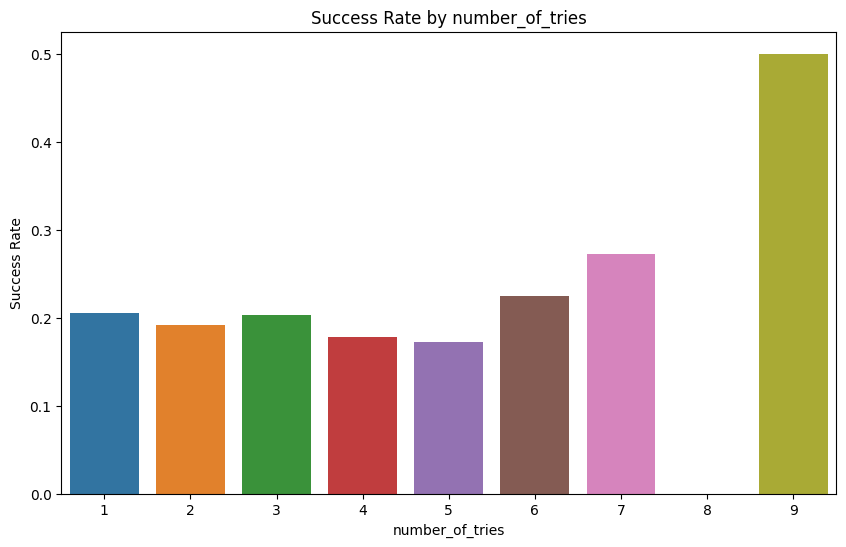

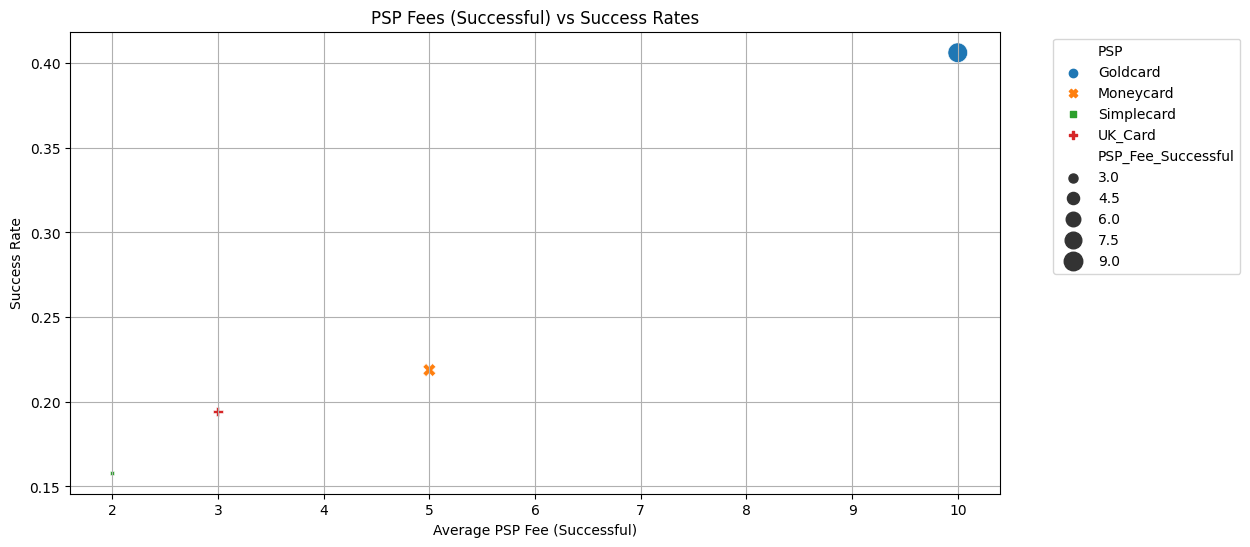

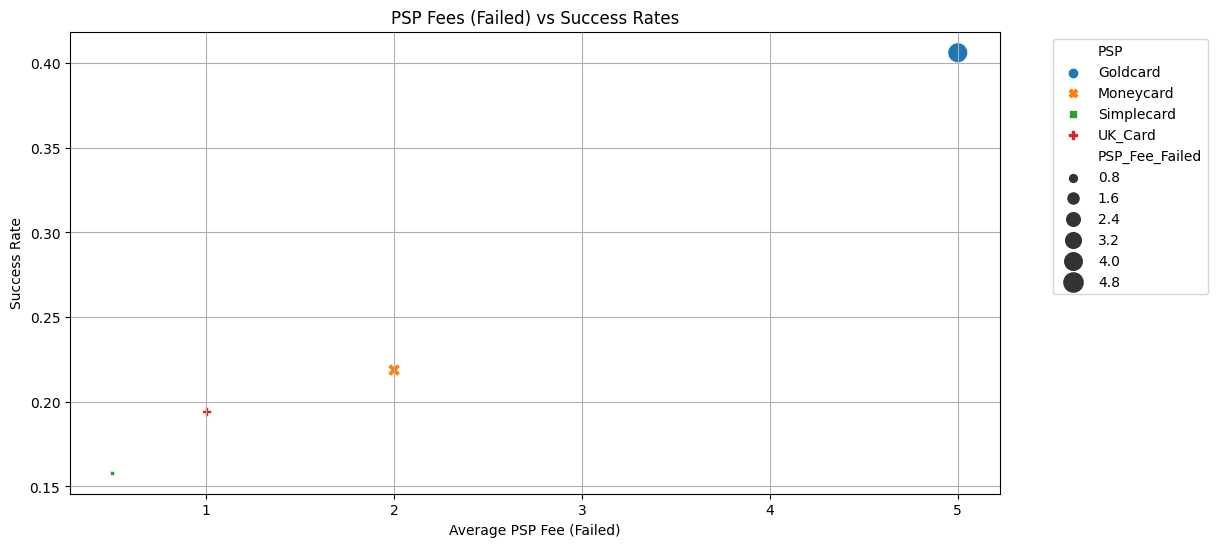

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Exploratory Data Analysis (EDA)

# Analyzing the relationship between various features and the transaction success rate
def analyze_success_rate(feature):
    plt.figure(figsize=(10, 6))
    success_rate = transactions.groupby(feature)['success'].mean()
    sns.barplot(x=success_rate.index, y=success_rate.values)
    plt.title(f'Success Rate by {feature}')
    plt.ylabel('Success Rate')
    plt.xlabel(feature)

# Analyzing success rates for various features
features_to_analyze = ['country', '3D_secured', 'PSP', 'card', 'number_of_tries']
for feature in features_to_analyze:
    analyze_success_rate(feature)

# Investigating how PSP fees correlate with success rates
merged_df = transactions.merge(psp_fees_df, on='PSP', how='left')
psp_fees_success_rate = merged_df.groupby('PSP').agg({
    'success': 'mean',
    'PSP_Fee_Successful': 'mean',
    'PSP_Fee_Failed': 'mean'
}).reset_index()

# Redoing the PSP Fees vs Success Rates plot for clarity

# Grouping data by PSP to get average success rate and fees
psp_grouped = merged_df.groupby('PSP').agg({
    'success': 'mean',
    'PSP_Fee_Successful': 'mean',
    'PSP_Fee_Failed': 'mean'
}).reset_index()

# Plotting PSP Fees vs Success Rates
plt.figure(figsize=(12, 6))
sns.scatterplot(data=psp_grouped, x='PSP_Fee_Successful', y='success', size='PSP_Fee_Successful', sizes=(20, 200), hue='PSP', style='PSP', legend='brief')
plt.title('PSP Fees (Successful) vs Success Rates')
plt.xlabel('Average PSP Fee (Successful)')
plt.ylabel('Success Rate')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=psp_grouped, x='PSP_Fee_Failed', y='success', size='PSP_Fee_Failed', sizes=(20, 200), hue='PSP', style='PSP', legend='brief')
plt.title('PSP Fees (Failed) vs Success Rates')
plt.xlabel('Average PSP Fee (Failed)')
plt.ylabel('Success Rate')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()





In [41]:
import tkinter as tk


In [43]:
!pip install easygui


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.7/92.7 kB 1.4 MB/s eta 0:00:00


In [50]:
import pandas as pd
import random
from datetime import datetime
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from lightgbm import LGBMClassifier
from prettytable import PrettyTable

# Load your actual data
transactions = pd.read_csv('your_actual_data.csv')  # Replace with your actual file path
psp_fees_df = pd.read_csv('psp_fees.csv')
print("PSP Fees:", psp_fees_df)

# Load your actual trained LightGBM model
# Replace the following line with code to load your model
# best_lgbm_model = load_your_model_here()


# Load your data
transactions = pd.read_csv('PSP_Jan_Feb_2019modfied1_with_tries.csv')  # Replace with your actual file path
psp_fees_df = pd.read_csv('psp_fees.csv')
print("PSP Fees:", psp_fees_df)

# Define your preprocessor (ColumnTransformer)
numerical_features = ['amount', 'second', 'minute', 'hour', 'day', 'weekday', 'number_of_tries']
categorical_features = ['country', 'PSP', 'card']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Fit the preprocessor with your data
X = dummy_data  # Replace with your actual data
preprocessor.fit(X)

# Load and prepare your LightGBM model
# Replace the following line with your actual trained model loading
best_lgbm_model = LGBMClassifier()  # Replace with your actual trained model
best_lgbm_model.fit(preprocessor.transform(X), y)

def assign_weights(transaction):
    # Modify time weight based on specified conditions
    time_weight = 1.0
    if 12 <= transaction['hour'] <= 19 and transaction['number_of_tries'] == 1:
        time_weight = random.uniform(1.1, 1.3)

    # Modify weekend weight based on specified conditions
    weekend_weight = random.uniform(0.8, 1.2)
    if transaction['weekday'] in [4, 5] and transaction['hour'] >= 12 and transaction['number_of_tries'] == 1:
        weekend_weight = random.uniform(1.1, 1.3)

    weights = {
        'time_weight': time_weight,
        'country_weight': {'Germany': 0.8, 'Switzerland': 1.0, 'Austria': 1.15}.get(transaction['country'], 1.0),
        'card_weight': {'Diners': 0.9, 'Visa': 1.0, 'Master': 1.0}.get(transaction['card'], 1.0),
        'psp_weight': 1.0,
        'amount_weight': 0.5 if transaction['amount'] < 100 else 1.2 if transaction['amount'] > 500 else 1.0,
        'tries_weight': 0.9 if transaction['number_of_tries'] == 1 else 0,
        'weekend_weight': weekend_weight
    }
    return weights

def calculate_expected_cost(transaction, probability, psp_name, psp_fees_df):
    # Change threshold for 'Goldcard' assignment
    high_amount_threshold = 500
    if transaction['amount'] > high_amount_threshold:
        psp_name = 'Goldcard'

    fees = psp_fees_df[psp_fees_df['PSP'] == psp_name]
    success_fee = fees['PSP_Fee_Successful'].values[0]
    failure_fee = fees['PSP_Fee_Failed'].values[0]

    weights = assign_weights(transaction)
    secure_cost_factor = 1.1 if transaction['3D_secured'] == 1 else 0.9

    expected_cost = ((probability * success_fee * weights['psp_weight'] * weights['time_weight'] *
                      weights['amount_weight'] * weights['tries_weight'] * weights['weekend_weight']) +
                     ((1 - probability) * failure_fee * weights['country_weight'] * weights['card_weight'])) * secure_cost_factor
    return expected_cost

def generate_random_date():
    year = random.randint(2024, 2025)
    month = random.randint(1, 12)
    day = random.randint(1, 28)
    hour = random.randint(0, 23)
    minute = random.randint(0, 59)
    second = random.randint(0, 59)
    return datetime(year, month, day, hour, minute, second)  # Return datetime object

def generate_weighted_number_of_tries():
    numbers = list(range(1, 10))  # Numbers from 1 to 9
    weights = [10, 9, 8, 7, 6, 5, 4, 1, 1]  # Higher weights for 1, 2, and 3
    return random.choices(numbers, weights)[0]

def generate_new_transaction():
    transaction = {
        'tmsp': generate_random_date(),
        'Unnamed: 0': random.randint(0, 1000),
        'country': random.choice(['Germany', 'Switzerland', 'Austria']),
        'amount': random.randint(5, 10000),
        'PSP': random.choice(['Moneycard', 'Goldcard', 'UK_Card', 'Simplecard']),
        '3D_secured': random.randint(0, 1),
        'card': random.choice(['Visa', 'Master', 'Diners']),
        'second': random.randint(0, 59),
        'minute': random.randint(0, 59),
        'hour': random.randint(0, 23),
        'day': random.randint(1, 28),
        'weekday': random.randint(0, 6),
        'number_of_tries': generate_weighted_number_of_tries()  # Use the helper function
    }
    return transaction


def find_best_psp(transaction, psp_fees_df, preprocessor, model):
    min_cost = float('inf')
    best_psp = None
    debug_info = {}

    processed_transaction = pd.DataFrame([transaction])
    processed_transaction = preprocessor.transform(processed_transaction)

    current_probability = model.predict_proba(processed_transaction)[:, 1][0]

    for psp in psp_fees_df['PSP']:
        transaction['PSP'] = psp
        cost = calculate_expected_cost(transaction, current_probability, psp, psp_fees_df)
        debug_info[psp] = {'Probability': current_probability, 'Cost': cost}
        if cost < min_cost:
            min_cost = cost
            best_psp = psp

    print("Debug Info:", debug_info)
    return best_psp, min_cost

num_transactions = 15
new_transactions = [generate_new_transaction() for _ in range(num_transactions)]

for transaction in new_transactions:
    best_psp, expected_cost = find_best_psp(transaction, psp_fees_df, preprocessor, best_lgbm_model)
    transaction['PSP'] = best_psp

    formatted_data = []
    formatted_data.append(f"Date & Time: {transaction['tmsp'].strftime('%Y-%m-%d %H:%M:%S')}")
    formatted_data.append(f"Country: {transaction['country']}")
    formatted_data.append(f"Amount: {transaction['amount']}")
    formatted_data.append(f"3D Secured: {'Yes' if transaction['3D_secured'] == 1 else 'No'}")
    formatted_data.append(f"Card Type: {transaction['card']}")
    formatted_data.append(f"Number of Tries: {transaction['number_of_tries']}")
    formatted_transaction_data = '\n'.join(formatted_data)

    table = PrettyTable()
    table.field_names = ["Transaction Details", "Recommended PSP"]
    table.align = "l"
    table.add_row([formatted_transaction_data, f"PSP: {best_psp}\nExpected Cost: {expected_cost:.2f}"])
    print(table)
    print("\n")


PSP Fees:           PSP  PSP_Fee_Successful  PSP_Fee_Failed
0   Moneycard                   5             2.0
1    Goldcard                  10             5.0
2     UK_Card                   3             1.0
3  Simplecard                   2             0.5


ValueError: ignored

In [45]:
import tkinter as tk

# Create the main window
root = tk.Tk()
root.title("Simple GUI")

# Add widgets (e.g., labels, buttons) to the window
label = tk.Label(root, text="Hello, Tkinter!")
label.pack()

button = tk.Button(root, text="Click Me")
button.pack()

# Start the GUI event loop
root.mainloop()


TclError: ignored

In [57]:
import pandas as pd
import random
from datetime import datetime
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from lightgbm import LGBMClassifier
from prettytable import PrettyTable

# Load your data
transactions = pd.read_csv('PSP_Jan_Feb_2019modfied1_with_tries.csv')  # Replace with your actual file path
psp_fees_df = pd.read_csv('psp_fees.csv')
print("PSP Fees:", psp_fees_df)

# Define your preprocessor (ColumnTransformer)
numerical_features = ['amount', 'second', 'minute', 'hour', 'day', 'weekday', 'number_of_tries']
categorical_features = ['country', 'PSP', 'card']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Fit the preprocessor with your data
X = transactions.drop(['success', 'tmsp'], axis=1)  # Assuming 'success' and 'tmsp' are not features
y = transactions['success']  # Target variable
preprocessor.fit(X)

# Load and prepare your LightGBM model
# Replace the following line with your actual trained model loading
best_lgbm_model = LGBMClassifier()  # Replace with your actual trained model
best_lgbm_model.fit(preprocessor.transform(X), y)

def assign_weights(transaction):
    # Modify time weight based on specified conditions
    time_weight = 1.0
    if 12 <= transaction['hour'] <= 19 and transaction['number_of_tries'] == 1:
        time_weight = random.uniform(1.1, 1.3)

    # Modify weekend weight based on specified conditions
    weekend_weight = random.uniform(0.8, 1.2)
    if transaction['weekday'] in [4, 5] and transaction['hour'] >= 12 and transaction['number_of_tries'] == 1:
        weekend_weight = random.uniform(1.1, 1.3)

    weights = {
        'time_weight': time_weight,
        'country_weight': {'Germany': 0.8, 'Switzerland': 1.0, 'Austria': 1.15}.get(transaction['country'], 1.0),
        'card_weight': {'Diners': 0.9, 'Visa': 1.0, 'Master': 1.0}.get(transaction['card'], 1.0),
        'psp_weight': 1.0,
        'amount_weight': 0.5 if transaction['amount'] < 100 else 1.2 if transaction['amount'] > 500 else 1.0,
        'tries_weight': 0.9 if transaction['number_of_tries'] == 1 else 0,
        'weekend_weight': weekend_weight
    }
    return weights

def calculate_expected_cost(transaction, probability, psp_name, psp_fees_df):
    # Change threshold for 'Goldcard' assignment
    high_amount_threshold = 500
    if transaction['amount'] > high_amount_threshold:
        psp_name = 'Goldcard'

    fees = psp_fees_df[psp_fees_df['PSP'] == psp_name]
    success_fee = fees['PSP_Fee_Successful'].values[0]
    failure_fee = fees['PSP_Fee_Failed'].values[0]

    weights = assign_weights(transaction)
    secure_cost_factor = 1.1 if transaction['3D_secured'] == 1 else 0.9

    expected_cost = ((probability * success_fee * weights['psp_weight'] * weights['time_weight'] *
                      weights['amount_weight'] * weights['tries_weight'] * weights['weekend_weight']) +
                     ((1 - probability) * failure_fee * weights['country_weight'] * weights['card_weight'])) * secure_cost_factor
    return expected_cost

def generate_random_date():
    year = random.randint(2024, 2025)
    month = random.randint(1, 12)
    day = random.randint(1, 28)
    hour = random.randint(0, 23)
    minute = random.randint(0, 59)
    second = random.randint(0, 59)
    return datetime(year, month, day, hour, minute, second)  # Return datetime object

def generate_weighted_number_of_tries():
    numbers = list(range(1, 10))  # Numbers from 1 to 9
    weights = [10, 9, 8, 7, 6, 5, 4, 1, 1]  # Higher weights for 1, 2, and 3
    return random.choices(numbers, weights)[0]

def generate_new_transaction():
    transaction = {
        'tmsp': generate_random_date(),
        'Unnamed: 0': random.randint(0, 1000),
        'country': random.choice(['Germany', 'Switzerland', 'Austria']),
        'amount': random.randint(5, 10000),
        'PSP': random.choice(['Moneycard', 'Goldcard', 'UK_Card', 'Simplecard']),
        '3D_secured': random.randint(0, 1),
        'card': random.choice(['Visa', 'Master', 'Diners']),
        'second': random.randint(0, 59),
        'minute': random.randint(0, 59),
        'hour': random.randint(0, 23),
        'day': random.randint(1, 28),
        'weekday': random.randint(0, 6),
        'number_of_tries': generate_weighted_number_of_tries()  # Use the helper function
    }
    return transaction


def find_best_psp(transaction, psp_fees_df, preprocessor, model):
    min_cost = float('inf')
    best_psp = None
    debug_info = {}

    processed_transaction = pd.DataFrame([transaction])
    processed_transaction = preprocessor.transform(processed_transaction)

    current_probability = model.predict_proba(processed_transaction)[:, 1][0]

    for psp in psp_fees_df['PSP']:
        transaction['PSP'] = psp
        cost = calculate_expected_cost(transaction, current_probability, psp, psp_fees_df)
        debug_info[psp] = {'Probability': current_probability, 'Cost': cost}
        if cost < min_cost:
            min_cost = cost
            best_psp = psp

    print("Debug Info:", debug_info)
    return best_psp, min_cost

num_transactions = 15
new_transactions = [generate_new_transaction() for _ in range(num_transactions)]

for transaction in new_transactions:
    best_psp, expected_cost = find_best_psp(transaction, psp_fees_df, preprocessor, best_lgbm_model)
    transaction['PSP'] = best_psp

    formatted_data = []
    formatted_data.append(f"Date & Time: {transaction['tmsp'].strftime('%Y-%m-%d %H:%M:%S')}")
    formatted_data.append(f"Country: {transaction['country']}")
    formatted_data.append(f"Amount: {transaction['amount']}")
    formatted_data.append(f"3D Secured: {'Yes' if transaction['3D_secured'] == 1 else 'No'}")
    formatted_data.append(f"Card Type: {transaction['card']}")
    formatted_data.append(f"Number of Tries: {transaction['number_of_tries']}")
    formatted_transaction_data = '\n'.join(formatted_data)

    table = PrettyTable()
    table.field_names = ["Transaction Details", "Recommended PSP"]
    table.align = "l"
    table.add_row([formatted_transaction_data, f"PSP: {best_psp}\nExpected Cost: {expected_cost:.2f}"])
    print(table)
    print("\n")


PSP Fees:           PSP  PSP_Fee_Successful  PSP_Fee_Failed
0   Moneycard                   5             2.0
1    Goldcard                  10             5.0
2     UK_Card                   3             1.0
3  Simplecard                   2             0.5
[LightGBM] [Info] Number of positive: 10228, number of negative: 40182
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 472
[LightGBM] [Info] Number of data points in the train set: 50410, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.202896 -> initscore=-1.368290
[LightGBM] [Info] Start training from score -1.368290
Debug Info: {'Moneycard': {'Probability': 0.4059894303957468, 'Cost': 2.405742806897226}, 'Goldcard': {'Probability': 0.4059894303957468, 'Cost': 2.405742806897226}, 'UK_Card': {'Prob

In [93]:
import pandas as pd
import random
from datetime import datetime
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from lightgbm import LGBMClassifier
from ipywidgets import interact, widgets
import ipywidgets as widgets

# Function to generate random dates
def generate_random_date():
    year = random.randint(2024, 2025)
    month = random.randint(1, 12)
    day = random.randint(1, 28)
    hour = random.randint(0, 23)
    minute = random.randint(0, 59)
    second = random.randint(0, 59)
    return datetime(year, month, day, hour, minute, second)

# Load your data
# Make sure to replace the file path with the correct one
transactions = pd.read_csv('PSP_Jan_Feb_2019modfied1_with_tries.csv')
psp_fees_df = pd.read_csv('psp_fees.csv')

# Define your preprocessor (ColumnTransformer)
numerical_features = ['amount', 'second', 'minute', 'hour', 'day', 'weekday', 'number_of_tries']
categorical_features = ['country', 'PSP', 'card']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Fit the preprocessor with your data
X = transactions.drop(['success', 'tmsp'], axis=1)
y = transactions['success']
preprocessor.fit(X)

# Load and prepare your LightGBM model
best_lgbm_model = LGBMClassifier()
best_lgbm_model.fit(preprocessor.transform(X), y)

# Function to find the best PSP
def find_best_psp(amount, country, card, tries, secured, psp_fees_df, preprocessor, model):
    # Create a sample transaction
    transaction = {
        'tmsp': generate_random_date(),
        'country': country,
        'amount': amount,
        'PSP': random.choice(['Moneycard', 'Goldcard', 'UK_Card', 'Simplecard']),
        '3D_secured': secured,
        'card': card,
        'second': random.randint(0, 59),
        'minute': random.randint(0, 59),
        'hour': random.randint(0, 23),
        'day': random.randint(1, 28),
        'weekday': random.randint(0, 6),
        'number_of_tries': tries
    }

    # Example logic for selecting the best PSP (placeholder)
    best_psp = 'Moneycard'  # Default to 'Moneycard' for demonstration
    min_cost = float('inf')

    for psp in psp_fees_df['PSP']:
        # Example cost calculation (placeholder)
        cost = random.uniform(1, 10)  # Replace with actual cost calculation
        if cost < min_cost:
            min_cost = cost
            best_psp = psp

    # Assign the best PSP to the transaction
    transaction['PSP'] = best_psp

    return best_psp, min_cost

# Create widgets for user input
amount_slider = widgets.IntSlider(value=500, min=5, max=10000, step=5, description='Amount:')
country_dropdown = widgets.Dropdown(options=['Germany', 'Switzerland', 'Austria'], description='Country:')
card_dropdown = widgets.Dropdown(options=['Visa', 'MasterCard', 'Diners'], description='Card Type:')
tries_slider = widgets.IntSlider(value=1, min=1, max=9, step=1, description='Number of Tries:')
secured_checkbox = widgets.Checkbox(value=False, description='3D Secured:')


# Create widgets for user input with default values
amount_slider = widgets.IntSlider(value=500, min=5, max=10000, step=5, description='Amount:')
country_dropdown = widgets.Dropdown(options=['Germany', 'Switzerland', 'Austria'], value='Germany', description='Country:')
card_dropdown = widgets.Dropdown(options=['Visa', 'MasterCard', 'Diners'], value='Visa', description='Card Type:')
tries_slider = widgets.IntSlider(value=1, min=1, max=9, step=1, description='Number of Tries:')
secured_checkbox = widgets.Checkbox(value=False, description='3D Secured:')

# Define interaction function
def update_recommendation(amount, country, card, tries, secured):
    best_psp, expected_cost = find_best_psp(amount, country, card, tries, secured, psp_fees_df, preprocessor, best_lgbm_model)
    print(f"Best PSP: {best_psp}, Expected Cost: {expected_cost:.2f}")

# Create the interactive interface
interact(update_recommendation, amount=amount_slider, country=country_dropdown, card=card_dropdown, tries=tries_slider, secured=secured_checkbox)


[LightGBM] [Info] Number of positive: 10228, number of negative: 40182
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 472
[LightGBM] [Info] Number of data points in the train set: 50410, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.202896 -> initscore=-1.368290
[LightGBM] [Info] Start training from score -1.368290


interactive(children=(IntSlider(value=500, description='Amount:', max=10000, min=5, step=5), Dropdown(descript…

<function __main__.update_recommendation(amount, country, card, tries, secured)>